In [1]:
import os
import re
import sys
import json
import pickle
import copy
import itertools
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib.ticker as ticker

In [4]:
sys.path.append(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(os.path.join(os.getcwd(), "..", "scripts"))

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
out_path = os.path.join("..", "derivatives", "TEMP")

# 1. Check dataset

### ... Prepare

In [7]:
from data_preparing import DataManager
from feature_engineering import FeatureReducer, FeatureSelector, BorutaSelector
from predict_age_ML import (
    Constants, Config, 
    convert_np_types, initialization, filter_features_preliminary, prepare_dataset, divide_and_preprocess_data
)

In [8]:
sys.argv = ['']
args, constants, config, logger = initialization()

In [9]:
# print(config.raw_data_path)

In [10]:
raw_data = pd.read_csv(config.raw_data_path)
raw_data.shape

(423, 2050)

In [11]:
DF_prepared = prepare_dataset(args, constants, config, logger)
DF_prepared.shape

(423, 1151)

In [12]:
preprocessed_data_dicts = divide_and_preprocess_data(DF_prepared, args, config, logger)

### 1-1. Plot data distribution

In [13]:
# ages = DF_prepared["BASIC_INFO_AGE"]
# print(min(ages), max(ages))

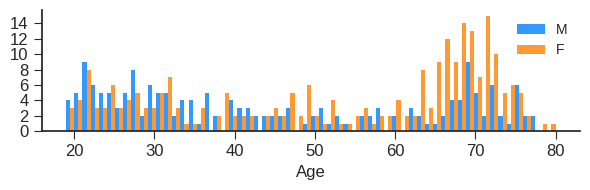

In [14]:
plt.style.use('seaborn-v0_8-ticks')
fig, ax = plt.subplots(figsize=(6, 2))
dat_1 = DF_prepared.query("BASIC_INFO_SEX == 1")["BASIC_INFO_AGE"]
dat_2 = DF_prepared.query("BASIC_INFO_SEX == 2")["BASIC_INFO_AGE"]
ax.hist(
    [dat_1, dat_2], 
    bins=np.linspace(19, 80, 61), rwidth=1, histtype='bar', 
    color=['#3399FF', '#FF9933'], # histtype='stepfilled', alpha=0.6, 
    label=[f"M", f"F"]
    # label=[f"Male (N = {len(dat_1)})", f"Female (N = {len(dat_2)})"]
)
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.tick_params(axis="both", which="major", labelsize=12)
ax.legend(loc=["upper left", "upper right"][1])
plt.tight_layout()
# plt.savefig(os.path.join(out_path, "Age distributions.png"), dpi=500)

### 1-2. Plot feature sunbursts 

In [15]:
# from gen_derivatives import make_feature_DF, ColorDicts
# from plotting import plot_feature_sunburst

In [16]:
# color_dicts = ColorDicts()

In [17]:
# domain_approach_mapping = { 
#     "STRUCTURE": {
#         "domains": ["STRUCTURE"],
#         "approaches": ["MRI"]
#     },
#     "BEH": {
#         "domains": ["MOTOR", "MEMORY", "LANGUAGE"],
#         "approaches": ["BEH"]
#     },
#     "FUNCTIONAL": {
#         "domains": ["MOTOR", "MEMORY", "LANGUAGE"],
#         "approaches": ["EEG", "MRI"]
#     }, 
#     "ALL": {
#         "domains": ["STRUCTURE", "MOTOR", "MEMORY", "LANGUAGE"], 
#         "approaches": ["MRI", "BEH", "EEG"]
#     }
# }

In [18]:
# for ori_name, ori_content in domain_approach_mapping.items():
    
#     DF_filtered = filter_features_preliminary(
#         DF_prepared, 
#         domains=ori_content["domains"], 
#         approaches=ori_content["approaches"] , 
#         ori_name=ori_name
#     )
#     feature_list = DF_filtered.columns
#     feature_DF = make_feature_DF(ori_name, feature_list, None)
    
#     plot_feature_sunburst(
#         feature_DF_dict=feature_DF, 
#         parent_col="approach_and_num", 
#         label_col="domain_and_num", 
#         color_dict=color_dicts.sunburst[ori_name], 
#         one_or_many="one", 
#         fig_title=ori_name[:3], 
#         output_path=os.path.join(out_path, f"2025-10-23 feature_sunburst ({ori_name[:3]}).png"), 
#         overwrite=True
#     )

### 1-3. Sampling ST features

In [19]:
from utils import ST_features

In [20]:
st_features = ST_features()

In [21]:
# [ x for x in raw_data.columns if ["_ST_RAW_", "_ST_NORM", "_ST_SCALED_"][0] in x ]

In [22]:
DF_prepared.set_index(["ID"], inplace=True)

In [23]:
DF_st = DF_prepared.loc[:, [x for x in DF_prepared.columns if "_ST_SCALED_" in x ]]

In [24]:
# DF_st.to_csv(os.path.join(out_path, "data_ST_SCALED.csv"))

In [25]:
# (
#     DF_st.agg(["min", "median", "mean", "max", "std"]).T.round(3)
#     .to_csv(os.path.join(out_path, "data_ST_SCALED_summ.csv"))
# )

In [26]:
# [ x.split("_")[-1] for x in DF_prepared.columns if "_ST_SCALED_" in x if x.startswith(["LANGUAGE", "MEMORY", "MOTOR"][2]) ]

In [27]:
# st_features_to_drop = [
#     [f"LANGUAGE_ST_SCALED_{f1}", f"MEMORY_ST_SCALED_{f2}", f"MOTOR_ST_SCALED_{f3}"]
#     for (f1, f2, f3) in list(itertools.product(
#         ['SIMILARITY', 'VOCABULARY', 'INFORMATION', 'SUM'], 
#         ['AudImm', 'VisImm', 'ImmMem', 'WorMem', 'LogMemI', 'FacI', 'VerPairI', 'FamPicI', 'LetNumSeq', 'SpaForward', 'SpaBackward', 'SpaTotal'], 
#         ['FineMotor', 'Balance', 'ProcessingSpeed']
#     ))
# ]

In [28]:
# domain_approach_mapping = {}
# for x, (f1, f2, f3) in enumerate(st_features_to_drop):
#     domain_approach_mapping[f"ST_{x+1}"] = {
#         "domains": [ f for f in st_features if f not in (f1, f2, f3) ], 
#         "approaches": [""]
#     }

# 2. Plot results (2025-11-07)

### ... Prepare

In [29]:
from gen_derivatives import (
    Constants, Description, load_model_results, force_agesex_cols
)
from plotting import (
    plot_categorical_bars, plot_bars_with_stats, plot_cormat, plot_color_legend
)

In [30]:
const = Constants()

In [31]:
from compare_versions import (
    Config, define_arguments, compare_pad_values
)

In [32]:
model_type = "XGBM"
x = 0
ds = ["testing", "entire"][x]
sys.argv = [
    'compare_versions.py', 
    '-v', '0', 
    '-ba', [f"2025-09-17_original_sex-0_{model_type}", 
            f"2025-09-17_original_sex-0 (2025-09-17_original_sex-0_{model_type})"][x], 
    '-un', [f"2025-09-17_original_age-0_sex-0_{model_type}", 
            f"2025-10-07_original_age-0_sex-0_tsr-0.0 (2025-09-17_original_age-0_sex-0_{model_type})"][x], 
    '-n', f"Original data ({ds} set), {model_type} model, no feature selection or reduction", 
    '-p', 'original_XGBM', 
    '-cbg', '0'
]
args = define_arguments()
custom_bar_x_lab = ["AgeGroup", "AgeSex"][args.custom_bar_x_lab] if args.custom_bar_x_lab is not None else None
config = Config(args)

In [33]:
version_list = list(config.input_folders.keys())
color_dict = dict(zip(version_list, sns.color_palette("husl", len(version_list))))

## 2-0. Load results

In [34]:
result_DF_list = []
args.ignore_all = False

for version, input_folder in config.input_folders.items():
    desc_json_path = os.path.join(input_folder, "description.json")
    with open(desc_json_path, 'r', errors='ignore') as f:
        desc_json = json.load(f)
    desc = Description(desc_json, const, args)

    config.result_path = os.path.join(input_folder, "results_{}_{}.json")
    result_DF, _, _ = load_model_results(
        config, desc, const, 
        output_path=os.path.join(out_path, f"results_DF_{version}.csv"), 
        overwrite=args.overwrite
    )
    result_DF["Version"] = version
    result_DF["VerType"] = result_DF["Version"] + "_" + result_DF["Type"]

    result_DF.rename(columns={"PredictedAgeDifference": "PAD", "CorrectedPAD": "PADAC",}, inplace=True)
    result_DF["PAD_abs"] = result_DF["PAD"].abs()
    result_DF["PADAC_abs"] = result_DF["PADAC"].abs()

    if args.custom_bar_x_lab is not None:
        data_DF = pd.read_csv(config.raw_data_path)
        data_DF["SID"] = data_DF["BASIC_INFO_ID"].map(lambda x: x.replace("sub-0", ""))
        temp_DF = force_agesex_cols(DF=result_DF, DF2=data_DF)
        temp_DF.rename(columns={custom_bar_x_lab: "BarGroup"}, inplace=True)
        result_DF = pd.merge(
            result_DF, temp_DF.loc[:, ["SID", "BarGroup"]], on="SID", how="left"
        )
            
    if "Sex" not in result_DF.columns:
        result_DF["Sex"] = ""
        result_DF.replace({"AgeGroup": {"le-44": "Y", "ge-45": "O"}}, inplace=True)
        result_DF.replace({"BarGroup": {"le-44": "Y", "ge-45": "O"}}, inplace=True)
    else:
        result_DF.replace({"AgeGroup": {"all": "", "le-44": "Y", "ge-45": "O"}}, inplace=True)
        result_DF.replace({"BarGroup": {"all": "", "le-44": "Y", "ge-45": "O"}}, inplace=True)
    
    result_DF["Group"] = result_DF["AgeGroup"] + result_DF["Sex"]
    result_DF_list.append(result_DF)

final_result_DF = pd.concat(result_DF_list, ignore_index=True)
final_result_DF.drop_duplicates(inplace=True)

Loading results_le-44_STRUCTURE.json ...
Loading results_le-44_BEH.json ...
Loading results_le-44_FUNCTIONAL.json ...
Loading results_le-44_ALL.json ...
Loading results_ge-45_STRUCTURE.json ...
Loading results_ge-45_BEH.json ...
Loading results_ge-45_FUNCTIONAL.json ...
Loading results_ge-45_ALL.json ...
Loading results_all_STRUCTURE.json ...
Loading results_all_BEH.json ...
Loading results_all_FUNCTIONAL.json ...
Loading results_all_ALL.json ...


In [35]:
# final_result_DF.head()

In [36]:
stats_DF_dict = {}
feature_orientations = final_result_DF["Type"].unique()

for pad_type in ["PAD", "PADAC"]:
    stats_DF_list = []
    
    for ori_name in feature_orientations:
        for group in ["Y", "O"]:
            for ver_1, ver_2 in itertools.combinations(version_list, 2):
                stats_results = compare_pad_values(
                    V1_abs=final_result_DF.query(
                        f"Type == '{ori_name}' & BarGroup == '{group}' & Version == '{ver_1}'"
                    )[f"{pad_type}_abs"], 
                    V2_abs=final_result_DF.query(
                        f"Type == '{ori_name}' & BarGroup == '{group}' & Version == '{ver_2}'"
                    )[f"{pad_type}_abs"], 
                    independent=True if args.different_participants else False
                )
                stats_results.insert(0, "Type", ori_name)
                stats_results.insert(1, "Group", group)
                stats_results.insert(2, "V1", ver_1)
                stats_results.insert(3, "V2", ver_2)
                stats_DF_list.append(stats_results)
    
    stats_DF = pd.concat(stats_DF_list, ignore_index=True)
    stats_DF_dict[pad_type] = stats_DF

## 2-1. PAD/PADAC bars

### 2-1-1. Test if an age-stratified approach improves prediction accuracy

In [37]:
temp_result_DF = (
    final_result_DF
    .loc[:, ["Version", "Type", "BarGroup", "SID", "PAD_abs", "PADAC_abs"]]
    .melt(id_vars=["Version", "Type", "BarGroup", "SID"], 
          value_vars=["PAD_abs", "PADAC_abs"], 
          var_name="var")
)
temp_result_DF["NewGroup"] = temp_result_DF["BarGroup"].astype(str) + "_" + temp_result_DF["var"]

In [38]:
temp_stats_DF_1 = stats_DF_dict["PAD"].copy(deep=True)
temp_stats_DF_1.insert(0, "var", "PAD")
temp_stats_DF_2 = stats_DF_dict["PADAC"].copy(deep=True)
temp_stats_DF_2.insert(0, "var", "PADAC")
temp_stats_DF = pd.concat(
    [temp_stats_DF_1, temp_stats_DF_2], 
    ignore_index=True
)

In [ ]:
temp_stats_DF.head(1)

In [ ]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [ ]:
pad_type = ["PAD", "PADAC"][1]

g = sns.catplot(
    data=temp_result_DF.query(f"var == '{pad_type}_abs'"), 
    x="BarGroup", y="value", col="Type", kind="bar", errorbar="se", sharex=False, 
    hue="Version", palette=sns.color_palette("Set2", 2), 
    height=5, aspect=.6, alpha=.8, legend=None
)

for col_val, ax in g.axes_dict.items():
    sub_stats_DF = temp_stats_DF.query(f"var == '{pad_type}' & Type == '{col_val}'")
    
    for group, x_pos in zip(["Y", "O"], [0, 1]):
        stats_res = sub_stats_DF.query(f"Group == '{group}'")
        p_val = stats_res.iloc[0]["P_value"]
        p_sig = stats_res.iloc[0]["P_sig"]
        # p_sig = "< .001 ***" if p_val < .001 else f"{p_val:.3f} {p_sig}"
        y_pos = max([stats_res["V1_mean"].max(), stats_res["V2_mean"].max()]) + 1.5
        
        if p_val < .05:
            ax.plot( [x_pos-.2, x_pos+.2], [y_pos, y_pos], color="k", lw=1.5)
            ax.plot( [x_pos-.2, x_pos-.2], [y_pos, y_pos-.3], color="k", lw=1.5)
            ax.plot( [x_pos+.2, x_pos+.2], [y_pos, y_pos-.3], color="k", lw=1.5)
            ax.text(x_pos, y_pos-.3, p_sig, 
                    ha="center", va="bottom", fontsize=20, fontdict={"style": "italic"})
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(col_val, fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=18)
    
g.set(ylim=(0, 12.9))
g.set_xlabels("")
g.set_ylabels("")
g.figure.tight_layout()
g.figure.savefig(os.path.join(out_path, f"2025-11-06 compare_PADAC_bars.png"))

In [ ]:
# pad_type = ["PAD", "PADAC"][1]
# color_dict = dict(zip(["Y", "O"], sns.color_palette("Set2", 2)))

# g = sns.catplot(
#     data=temp_result_DF.query(f"var == '{pad_type}_abs'"), 
#     x="Version", y="value", col="Type", kind="bar", errorbar="se", sharex=False, 
#     hue="BarGroup", hue_order=["Y", "O"], palette=color_dict, 
#     height=5, aspect=.6, alpha=.8, legend=None
# )

# for col_val, ax in g.axes_dict.items():
#     sub_stats_DF = temp_stats_DF.query(f"var == '{pad_type}' & Type == '{col_val}'")
#     y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()]) + .5
    
#     for group, x_pos in zip(["Y", "O"], [-.2, .2]):
#         stats_res = sub_stats_DF.query(f"Group == '{group}'")
#         p_val = stats_res.iloc[0]["P_value"]
#         p_sig = stats_res.iloc[0]["P_sig"]
#         # p_sig = "< .001 ***" if p_val < .001 else f"{p_val:.3f} {p_sig}"
        
#         if p_val < .05:
#             y_pos += 1 # offset
#             ax.plot( [x_pos, x_pos+1], [y_pos, y_pos], color="k", lw=1.5)
#             ax.plot( [x_pos, x_pos], [y_pos, y_pos-.3], color="k", lw=1.5)
#             ax.plot( [x_pos+1, x_pos+1], [y_pos, y_pos-.3], color="k", lw=1.5)
#             ax.text((x_pos+.5), y_pos-.4, p_sig, 
#                     ha="center", va="bottom", fontsize=19, fontdict={"style": "italic"})
    
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.set_title(col_val, fontsize=20)
#     ax.tick_params(axis="both", which="major", labelsize=18)
    
# g.set(ylim=(0, 14.9))
# g.set_xlabels("")
# g.set_ylabels("")
# g.figure.tight_layout()
# g.figure.savefig(os.path.join(out_path, f"2025-11-06 compare_PADAC_bars.png"))

#### PAD and PADAC in same plot

In [ ]:
temp_stats_DF["NewGroup"] = temp_stats_DF["Group"] + "_" + temp_stats_DF["var"]

In [ ]:
color_list = ["#E1712B", "#FE9A37", "#2A9689", "#36BBA7"]
hatches = itertools.cycle(['', '//'])

g = sns.catplot(
    data=temp_result_DF, 
    x="Version", y="value", col="Type", kind="bar", errorbar="se", sharex=False, 
    hue="NewGroup", hue_order=["Y_PAD_abs", "Y_PADAC_abs", "O_PAD_abs", "O_PADAC_abs"], palette=color_list, 
    height=5, aspect=.6, alpha=.8, legend=None
)

for col_val, ax in g.axes_dict.items():
    sub_stats_DF = temp_stats_DF.query(f"Type == '{col_val}'")
    y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()]) + .7
    
    for group, x_pos in zip(["Y_PAD", "Y_PADAC", "O_PAD", "O_PADAC"], np.linspace(-.3, .3, 4)):
        stats_res = sub_stats_DF.query(f"NewGroup == '{group}'")
        p_val = stats_res.iloc[0]["P_value"]
        p_sig = stats_res.iloc[0]["P_sig"]
        
        if p_val < .05:
            y_pos += 1 # offset
            ax.plot( [x_pos, x_pos+1], [y_pos, y_pos], color="k", lw=1.5)
            ax.plot( [x_pos, x_pos], [y_pos, y_pos-.3], color="k", lw=1.5)
            ax.plot( [x_pos+1, x_pos+1], [y_pos, y_pos-.3], color="k", lw=1.5)
            ax.text((x_pos+.5), y_pos-.5, p_sig, 
                    ha="center", va="bottom", fontsize=19, fontdict={"style": "italic"})
            
    for i, bar in enumerate(ax.patches):
        if i % 2 == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.set_title(col_val, fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=18)
    
g.set(ylim=(0, 17.9))
g.set_xlabels("")
g.set_ylabels("")
g.figure.tight_layout()
g.figure.savefig(os.path.join(out_path, f"2025-10-24 compare_PAD+PADAC_bars.png"))

### 2-1-2. Compare models trained using features in specific modalities

In [ ]:
stats_DF_list = []

for version in ["ByAge", "Undivided"]:
    for group in ["Y", "O"]:
        for pad_type in ["PAD", "PADAC"]:
            for ori_1, ori_2 in itertools.combinations(feature_orientations, 2):
                stats_results = compare_pad_values(
                    V1_abs=final_result_DF.query(
                        f"Version == '{version}' & BarGroup == '{group}' & Type == '{ori_1}'"
                    )[f"{pad_type}_abs"], 
                    V2_abs=final_result_DF.query(
                        f"Version == '{version}' & BarGroup == '{group}' & Type == '{ori_2}'"
                    )[f"{pad_type}_abs"], 
                    independent=True if args.different_participants else False
                )
                stats_results.insert(0, "Version", version)
                stats_results.insert(1, "Group", group)
                stats_results.insert(2, "PAD_type", pad_type)
                stats_results.insert(3, "V1", ori_1)
                stats_results.insert(4, "V2", ori_2)
                stats_DF_list.append(stats_results)
                
new_stats_DF = pd.concat(stats_DF_list, ignore_index=True)

In [ ]:
temp_result_DF.head(1)

In [ ]:
temp_result_DF["NewGroup2"] = temp_result_DF["Version"] + "_" + temp_result_DF["BarGroup"].astype(str)

In [ ]:
my_palette = [
    list(sns.color_palette("husl", 5))[0], 
    list(sns.color_palette("husl", 5))[1], 
    list(sns.color_palette("husl", 5))[3], 
    list(sns.color_palette("husl", 5))[4]
]

In [ ]:
pad_type = ["PAD", "PADAC"][1]

g = sns.catplot(
    data=temp_result_DF.query(f"var == '{pad_type}_abs'"), 
    x="Type", y="value", col="NewGroup2", kind="bar", errorbar="se", sharex=False, 
    hue="Type", hue_order=["STR", "BEH", "FUN", "ALL"], palette=my_palette, 
    height=5, aspect=.6, alpha=.8, legend=None
)

x_pos_dict = dict(zip(feature_orientations, range(4)))

for col_val, ax in g.axes_dict.items():
    version, group = col_val.split("_")
    sub_stats_DF = new_stats_DF.query(f"Version == '{version}' & Group == '{group}' & PAD_type == '{pad_type}'")
    y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()]) + .5

    for ori_1, ori_2 in itertools.combinations(feature_orientations, 2):
        stats_res = sub_stats_DF.query(f"V1 == '{ori_1}' & V2 == '{ori_2}'")
        p_val = stats_res.iloc[0]["P_value"]
        p_sig = stats_res.iloc[0]["P_sig"]
            
        if p_val < .05:
            x_pos_1 = x_pos_dict[ori_1]
            x_pos_2 = x_pos_dict[ori_2]
            y_pos += 1.1 # offset
            ax.plot( [x_pos_1, x_pos_2], [y_pos, y_pos], color="k", lw=1.5)
            ax.plot( [x_pos_1, x_pos_1], [y_pos, y_pos-.2], color="k", lw=1.5)
            ax.plot( [x_pos_2, x_pos_2], [y_pos, y_pos-.2], color="k", lw=1.5)
            ax.text(np.mean([x_pos_1, x_pos_2]), y_pos-.5, p_sig, 
                    ha="center", va="bottom", fontsize=20, fontdict={"style": "italic"})
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(col_val, fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=18)
    
g.set(ylim=(0, 15.9))
g.set_xlabels("")
g.set_ylabels("")
g.figure.tight_layout()
g.figure.savefig(os.path.join(out_path, f"2025-11-05 compare_PADAC_bars (2).png"))

#### PAD and PADAC in same plot

In [ ]:
# temp_result_DF["var"] = temp_result_DF["var"].map({"PAD_abs": "original", "PADAC_abs": "corrected"})

In [ ]:
# g = sns.catplot(
#     data=temp_result_DF, 
#     x="var", y="value", col="NewGroup2", kind="bar", errorbar="se", sharex=False, 
#     hue="Type", hue_order=["STR", "BEH", "FUN", "ALL"], palette=sns.color_palette("husl", 4), 
#     height=5, aspect=.6, alpha=.8, legend=None
# )

# x_pos_dict = {
#     "PAD": dict(zip(feature_orientations, np.linspace(-.3, .3, 4))), 
#     "PADAC": dict(zip(feature_orientations, np.linspace(-.3, .3, 4) + 1))
# }
# for col_val, ax in g.axes_dict.items():
#     version, group = col_val.split("_")

#     for pad_type in ["PAD", "PADAC"]: 
#         sub_stats_DF = new_stats_DF.query(f"Version == '{version}' & Group == '{group}' & PAD_type == '{pad_type}'")
#         y_pos = max([sub_stats_DF["V1_mean"].max(), sub_stats_DF["V2_mean"].max()])

#         for ori_1, ori_2 in itertools.combinations(feature_orientations, 2):
#             stats_res = sub_stats_DF.query(f"V1 == '{ori_1}' & V2 == '{ori_2}'")
#             p_val = stats_res.iloc[0]["P_value"]
#             p_sig = stats_res.iloc[0]["P_sig"]
            
#             if p_val < .05:
#                 x_pos_1 = x_pos_dict[pad_type][ori_1]
#                 x_pos_2 = x_pos_dict[pad_type][ori_2]
#                 y_pos += 2.5 # offset
#                 ax.plot( [x_pos_1, x_pos_2], [y_pos, y_pos], color="k", lw=1.5)
#                 ax.plot( [x_pos_1, x_pos_1], [y_pos, y_pos-.3], color="k", lw=1.5)
#                 ax.plot( [x_pos_2, x_pos_2], [y_pos, y_pos-.5], color="k", lw=1.5)
#                 ax.text(np.mean([x_pos_1, x_pos_2]), y_pos-.5, p_sig, 
#                         ha="center", va="bottom", fontsize=20, fontdict={"style": "italic"})

#     for i, bar in enumerate(ax.patches):
#         if i % 2 == 1:
#             bar.set_hatch('//')
    
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
#     ax.set_title(col_val, fontsize=20)
#     ax.tick_params(axis="both", which="major", labelsize=18)
    
# g.set(ylim=(0, 23))
# g.figure.tight_layout()
# g.set_xlabels("")
# g.set_ylabels("")
# g.figure.savefig(os.path.join(out_path, f"2025-10-24 compare_PAD+PADAC_bars (2).png"))

## 2-2. Correlation matrices

### ... Prepare

In [ ]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
from utils import basic_Q_features, ST_features
basic_q_features = basic_Q_features()
st_features = ST_features()

In [ ]:
sub_DF_Y = final_result_DF.query("Version == 'ByAge' & AgeGroup == 'Y'")
sub_DF_O = final_result_DF.query("Version == 'ByAge' & AgeGroup == 'O'")
sub_DF_Un = final_result_DF.query("Version == 'Undivided'")
data_DF_interested = data_DF.loc[:, ["SID"] + basic_q_features + st_features]

In [ ]:
sub_df_dict = {}

for pad_type in ["PAD", "PADAC"]:
    sub_df_dict[pad_type] = {}
    
    for group_name, sub_df in zip(["Y", "O", "Un"], [sub_DF_Y, sub_DF_O, sub_DF_Un]):
        sub_df = (
            sub_df.loc[:, ["Type", "SID", pad_type]]
            .pivot(index="SID", columns="Type", values=pad_type)
            .reset_index()
            .rename(columns={"index": "SID"})
        )
        sub_df_dict[pad_type][group_name] = sub_df.merge(data_DF_interested, on="SID", how="left")

### 2-2-1. Among PAC(AC) values

In [ ]:
for pad_type in ["PAD", "PADAC"]:
    for group_name in ["Y", "O", "Un"]:
        targ_df = sub_df_dict[pad_type][group_name].loc[:, sorted(desc.feature_oris)]
        cormat = targ_df.corr()
        mask = np.zeros_like(cormat)
        mask[np.triu_indices_from(mask)] = True
        
        sns.set_theme(style='white', font_scale=1.2)
        plt.figure(figsize=(4, 3), dpi=200)
        g = sns.heatmap(
            cormat, mask=mask, # square=True, 
            vmin=-1, vmax=1, linewidth=.5, cmap="RdBu_r", cbar=False, 
            annot=True, fmt = ".2f", annot_kws={"size": 16}, 
        )
        plt.tight_layout()
        # plt.savefig(os.path.join(out_path, f"2025-11-05 {pad_type} cormat ({group_name}).png"))
        # plt.close()

### 2-2-2. Between PAD(AC) and standardized test or questionnaire

In [ ]:
def create_annot_mat(cormat, p_stacked, fdr=0.05):
    q_vals = fdrcorrection(p_stacked.dropna().values, alpha=fdr)[1]
    q_stacked = pd.Series(q_vals, index=p_stacked.index)
    q_mat = q_stacked.unstack()
    # q_sig = q_mat.map(lambda x: "*" * sum( x <= t for t in [0.05, 0.01, 0.001] ))
    # annot_mat = cormat.map(lambda x: f"{x:.2f}") + q_sig.reindex_like(cormat)
    q_mask = q_mat < .05
    annot_mat = cormat.map(lambda x: f"{x:.2f}") * q_mask.reindex_like(cormat)
    return annot_mat.fillna("--")

In [ ]:
basic_q_names = [
    "Edinburgh Handedness Inventory, Sum", 
    "Physical Function", 
    "Physical Limit", 
    "Emotional Well", 
    "Emotional Limit", 
    "Energy", 
    "Social Function", 
    "Pain", 
    "General Health", 
    "Physical", 
    "Mental", 
    "Sleep Quality", 
    "Sleep Latency", 
    "Sleep Duration", 
    "Sleep Efficiency", 
    "Sleep Disturbance", 
    "Sleep Medication", 
    "Daytime Dysfunction", 
    "Sum", 
    "IPAQ, Metabolic Equivalent of Task", 
    "Extraversion", 
    "Agreeableness", 
    "Conscientiousness", 
    "Emotional Stability", 
    "Intellect", 
    "Multidimensional Scale of Perceived Social Support, Sum", 
    "Cognitive Failure Scale, Sum", 
    "Anxiety", 
    "Depression", 
    "Montreal Cognitive Assessment, Sum" 
]

In [ ]:
st_names = [
    "Similarity", 
    "Vocabulary", 
    "Information", 
    "Auditory Immediate", 
    "Visual Immediate", 
    "Working Memory", 
    "Logical Memory 1", 
    "Facial Memory 1", 
    "Verbal Pair 1", 
    "Family Picture 1", 
    "Letter Number Sequence", 
    "Spatial Forward", 
    "Spatial Backward", 
    "Fine Motor", 
    "Balance", 
    "Processing Speed" 
]

In [ ]:
# x_cols = sorted(desc.feature_oris)

# pad_type = ["PAD", "PADAC"][1]
# # for pad_type in ["PAD", "PADAC"]:

# for y_title, y_names, y_cols, fig_size in zip(
#     ["questionnaire", "standardized test"], 
#     [basic_q_names, st_names], 
#     [basic_q_features, st_features], 
#     [(12, 11), (8, 7)]
# ):
#     for group_name in ["Y", "O", "Un"]:
#         sub_df = sub_df_dict[pad_type][group_name]
#         cormat = pd.DataFrame(index=y_cols, columns=x_cols, dtype=float)
#         p_mat = pd.DataFrame(index=y_cols, columns=x_cols, dtype=str)
#         for t1 in y_cols:
#             for t2 in x_cols:
#                 targ_df = sub_df[[t1, t2]].dropna()
#                 cormat.loc[t1, t2], p_mat.loc[t1, t2] = pearsonr(targ_df[t1], targ_df[t2])
#         p_stacked = p_mat.stack()
#         annot_mat = create_annot_mat(cormat, p_stacked)
#         mask = None
        
#         sns.set_theme(style='white', font_scale=1.1)
#         plt.figure(figsize=fig_size, dpi=200)
#         g = sns.heatmap(
#             cormat, mask=mask, square=False, 
#             vmin=-1, vmax=1, linewidth=.5, cmap="RdBu_r", cbar=False, 
#             # cbar=True, cbar_kws={"shrink": 0.5, "label": "$r$"}, 
#             annot=pd.DataFrame(annot_mat), fmt = "", annot_kws={"size": 18}, 
#             xticklabels=x_cols, yticklabels=y_names
#         )
#         g.set(xlabel="", ylabel="")
#         g.tick_params(axis="both", which="major", labelsize=20)
#         plt.tight_layout()
#         plt.savefig(os.path.join(out_path, f"2025-11-06 {pad_type} corwith {y_title} features ({group_name}).png"))
#         plt.close()

In [ ]:
# plt.figure(figsize=(2, 9))
# plt.imshow(np.array([[-1, 1]]), cmap="RdBu_r")
# plt.gca().set_visible(False)
# plt.colorbar(orientation="vertical")
# plt.tight_layout()
# # plt.savefig(os.path.join(out_path, "colorbar.jpg"))
# plt.close()

In [ ]:
seed = np.random.randint(0, 10000)
N = 64

x_cols = sorted(desc.feature_oris)

pad_type = ["PAD", "PADAC"][1]
group_name = ["Y", "O", "Un"][2]

for y_title, y_names, y_cols, fig_size in zip(
    ["questionnaire", "standardized test"], 
    [basic_q_names, st_names], 
    [basic_q_features, st_features], 
    [(12, 11), (8, 7)]
):
    sub_df = sub_df_dict[pad_type][group_name].sample(n=N, random_state=seed)
    
    cormat = pd.DataFrame(index=y_cols, columns=x_cols, dtype=float)
    p_mat = pd.DataFrame(index=y_cols, columns=x_cols, dtype=str)
    for t1 in y_cols:
        for t2 in x_cols:
            targ_df = sub_df[[t1, t2]].dropna()
            cormat.loc[t1, t2], p_mat.loc[t1, t2] = pearsonr(targ_df[t1], targ_df[t2])
    p_stacked = p_mat.stack()
    annot_mat = create_annot_mat(cormat, p_stacked)
    mask = None
    
    sns.set_theme(style='white', font_scale=1.1)
    plt.figure(figsize=fig_size, dpi=200)
    g = sns.heatmap(
        cormat, mask=mask, square=False, 
        vmin=-1, vmax=1, linewidth=.5, cmap="RdBu_r", cbar=False, 
        # cbar=True, cbar_kws={"shrink": 0.5, "label": "$r$"}, 
        annot=pd.DataFrame(annot_mat), fmt = "", annot_kws={"size": 18}, 
        xticklabels=x_cols, yticklabels=y_names
    )
    g.set(xlabel="", ylabel="")
    g.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.savefig(os.path.join(out_path, f"2025-11-07 {pad_type} corwith {y_title} features ({group_name}; N={N}; {seed}).png"))
    # plt.close()

# 3. Check results (2025-12-03)

### ... Prepare

In [ ]:
from gen_derivatives import Constants, Config, Description, define_arguments, load_model_results

In [ ]:
sys.argv = [
    "", "-f", 
    ["2025-09-17_original_sex-0_XGBM", 
     "2025-09-17_original_sex-0 (2025-09-17_original_sex-0_XGBM)"][0]
]

In [ ]:
const = Constants()
args = define_arguments()
config = Config(args)
os.makedirs(config.output_folder, exist_ok=True)

In [ ]:
# vars(config)

In [ ]:
with open(config.desc_path, 'r', errors='ignore') as f:
    desc_json = json.load(f)

desc = Description(desc_json, const, args)

In [ ]:
result_DF, combined_results_DF, selected_features = load_model_results(
    config, desc, const, 
    output_path=config.model_results_outpath,
    overwrite=args.overwrite
)

In [ ]:
# print(result_DF.shape, combined_results_DF.shape)

In [ ]:
# print(result_DF.columns, combined_results_DF.columns)

In [ ]:
result_DF.rename(columns={
    "PredictedAgeDifference": "PAD", 
    "CorrectedPAD": "PAD_ac"
}, inplace=True)

result_DF_O = result_DF.query("AgeGroup == 'O'")

pad_type = ["PAD", "PAD_ac"][1]

### 3-1. Correlation between the corrected predicted age and chronological age:

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
for ori in desc.feature_oris:
    training_set_idx = combined_results_DF.query(f"Type == '{ori}' & TrainTest == 'Train'").index
    y_train = combined_results_DF.loc[training_set_idx, "Age"]
    y_pred_train = combined_results_DF.loc[training_set_idx, "PredictedAge"]
    pads = y_pred_train - y_train
    reg  = LinearRegression().fit(X=y_train.to_numpy().reshape(-1, 1), y=pads.to_numpy())
    padac_train = y_pred_train * reg.coef_ + reg.intercept_
    combined_results_DF.loc[training_set_idx, "PAD_ac2"] = padac_train
    
    testing_set_idx  = combined_results_DF.query(f"Type == '{ori}' & TrainTest == 'Test'").index
    y_pred_test = combined_results_DF.loc[testing_set_idx, "PredictedAge"]
    padac_test = y_pred_test * reg.coef_ + reg.intercept_
    combined_results_DF.loc[testing_set_idx, "PAD_ac2"] = padac_test

In [ ]:
def sig_p(p):
    return f"{'< .001' if p < .001 else ('= ' + str(round(p, 4)).lstrip('0'))} {'*' * sum( p <= t for t in [0.05, 0.01, 0.001] )}"

In [ ]:
sns.set(style='whitegrid', font_scale=1.5)
fig = plt.figure(figsize=(20, 5), dpi=200) 

for i, ori in enumerate(desc.feature_oris):
    # dat = combined_results_DF.query(f"Type == '{ori}' & TrainTest == 'Test'")
    dat = combined_results_DF.query(f"Type == '{ori}'")
    x_val = dat["Age"]
    y_val = dat["PAD_ac2"]
    r, p_r = stats.pearsonr(x_val, y_val)
    n = len(x_val)
    F = (r**2 / (1 - r**2)) * (n - 2)
    p_F = 1 - stats.f.cdf(F, 1, n-2)
    m, c = np.polyfit(x_val, y_val, 1)
    
    plt.subplot(1, 4, i+1)
    g = sns.regplot(
        data=dat, x="Age", y="PAD_ac2", 
        x_jitter=False, y_jitter=False, 
        scatter_kws={'s': 100, 'alpha': 0.5, 'edgecolor': 'white'}, line_kws={'linewidth': 1}
    )
    g.set(
        xlim=(15, 85), ylim=(-20, 20), 
        xticks=np.arange(20, 85, 10), yticks=np.arange(-20, 20, 5), 
        xlabel="", ylabel="", title=ori
    )
    g.axhline(
        0, color="r", linewidth=1, linestyle="--"
    )
    g.text(
        0.5, 0.9, f"$r$ = {r:.2f}, $p$ {sig_p(p_r)}, N = {n}", 
        transform=g.transAxes, ha='center', linespacing=1.5, fontsize=16
    )
    g.text(
        0.5, 0.05, f"y = {c:.2f} + {m:.2f}x\n$F$({1}, {n-2}) = {F:.2f}, $p$ {sig_p(p_F)}", 
        transform=g.transAxes, ha='center', linespacing=1.5, fontsize=14
    )

fig.tight_layout(rect=[0.02, 0, 1, 1])
fig.supxlabel("Chronological Age", fontsize=18)
fig.supylabel("Corrected PAD", fontsize=18)
# plt.savefig(os.path.join(config.output_folder, f"[regress] Cole corrected PAD x real age.png"))
plt.savefig(os.path.join(config.output_folder, f"[regress] Cole corrected PAD x real age (entire).png"))

plt.close()

In [ ]:
# sns.set(style='whitegrid', font_scale=1.5)
# fig = plt.figure(figsize=(20, 5), dpi=200) 

# for i, ori in enumerate(desc.feature_oris):
#     dat = result_DF.query(f"Type == '{ori}'")
#     x_val = dat["Age"]
#     y_val = dat["PAD_ac"]
#     r, p_r = stats.pearsonr(x_val, y_val)
#     n = len(x_val)
#     F = (r**2 / (1 - r**2)) * (n - 2)
#     p_F = 1 - stats.f.cdf(F, 1, n-2)
#     m, c = np.polyfit(x_val, y_val, 1)
    
#     plt.subplot(1, 4, i+1)
#     g = sns.regplot(
#         data=dat, x="Age", y="PAD_ac", 
#         x_jitter=False, y_jitter=False, 
#         scatter_kws={'s': 100, 'alpha': 0.5, 'edgecolor': 'white'}, line_kws={'linewidth': 1}
#     )
#     g.set(
#         xlim=(15, 85), ylim=(-20, 20), 
#         xticks=np.arange(20, 85, 10), yticks=np.arange(-20, 20, 5), 
#         xlabel="", ylabel="", title=ori
#     )
#     g.axhline(
#         0, color="r", linewidth=1, linestyle="--"
#     )
#     g.text(
#         0.5, 0.9, f"$r$ = {r:.2f}, $p$ {sig_p(p_r)}, N = {n}", 
#         transform=g.transAxes, ha='center', linespacing=1.5, fontsize=16
#     )
#     g.text(
#         0.5, 0.05, f"y = {c:.2f} + {m:.2f}x\n$F$({1}, {n-2}) = {F:.2f}, $p$ {sig_p(p_F)}", 
#         transform=g.transAxes, ha='center', linespacing=1.5, fontsize=14
#     )

# fig.tight_layout(rect=[0.02, 0, 1, 1])
# fig.supxlabel("Chronological Age", fontsize=18)
# fig.supylabel("Corrected PAD", fontsize=18)
# plt.savefig(os.path.join(config.output_folder, f"[regress] corrected PAD x real age.png"))
# plt.close()

In [ ]:
# sns.set(style='whitegrid', font_scale=1.5)
# fig = plt.figure(figsize=(20, 5.2), dpi=200) 

# for i, ori in enumerate(desc.feature_oris):
#     dat = result_DF.query(f"Type == '{ori}'")
#     x_val = dat["Age"]
#     y_val = dat["CorrectedPredictedAge"]
#     r, p_r = stats.pearsonr(x_val, y_val)
#     n = len(x_val)
#     F = (r**2 / (1 - r**2)) * (n - 2)
#     p_F = 1 - stats.f.cdf(F, 1, n-2)
#     m, c = np.polyfit(x_val, y_val, 1)
    
#     plt.subplot(1, 4, i+1)
#     g = sns.regplot(
#         data=dat, x="Age", y="CorrectedPredictedAge", 
#         x_jitter=False, y_jitter=False, 
#         scatter_kws={'s': 100, 'alpha': 0.5, 'edgecolor': 'white'}, line_kws={'linewidth': 1}
#     )
#     g.set(
#         xlim=(15, 85), ylim=(15, 85), 
#         xticks=np.arange(20, 85, 10), yticks=np.arange(20, 85, 10), 
#         xlabel="", ylabel="", title=ori
#     )
#     g.plot(
#         g.get_xlim(), g.get_ylim(), color="r", linewidth=1, linestyle="--"
#     )
#     g.text(
#         0.05, 0.8, f"$r$ = {r:.2f}, $p$ {sig_p(p_r)}\nN = {n}", 
#         transform=g.transAxes, ha='left', linespacing=1.5, fontsize=18
#     )
#     g.text(
#         0.7, 0.05, f"y = {c:.2f} + {m:.2f}x\n$F$({1}, {n-2}) = {F:.2f}\n$p$ {sig_p(p_F)}", 
#         transform=g.transAxes, ha='center', linespacing=1.5, fontsize=16, color="b"
#     )

# fig.tight_layout(rect=[0.02, 0, 1, 1])
# fig.supxlabel("Chronological Age", fontsize=18)
# fig.supylabel("Corrected Predicted Age", fontsize=18)
# plt.savefig(os.path.join(config.output_folder, f"[regress] corrected predicted x real age.png"))
# plt.close()

### 3-2. Split the "Old" group (>45) into high and low performers, 
and check if the positive correlation exist only in the high performers. 

In [ ]:
wide_result_DF_O = (
    result_DF_O.loc[:, ["Type", "SID", "Age", pad_type]]
    .pivot(index="SID", columns="Type", values=pad_type)
)
wide_result_DF_O["mean"] = wide_result_DF_O.mean(axis=1)
wide_result_DF_O["group"] = pd.qcut(wide_result_DF_O["mean"], 2, labels=["high", "low"]) 
wide_result_DF_O = pd.merge(
    result_DF.loc[:, ["SID", "Age"]].drop_duplicates().set_index("SID"), 
    wide_result_DF_O, 
    left_index=True, right_index=True, how='right'
)
result_DF_O_gby = {
    "high": wide_result_DF_O.query("group == 'high'"), 
    "low": wide_result_DF_O.query("group == 'low'"), 
    "all": wide_result_DF_O
}

In [ ]:
wide_result_DF_O.to_csv(os.path.join(config.output_folder, f"wide_results.csv"))

In [ ]:
sns.set_theme(style='white', font_scale=1.5)
fig = plt.figure(figsize=(12, 3), dpi=200) 

for i, (k, x) in enumerate(result_DF_O_gby.items()):
    wide_df = x.loc[:, sorted(desc.feature_oris)]
    cormat = wide_df.corr()
    mask_upper = np.triu(np.ones_like(cormat, dtype=bool))
    cormat_lower = cormat.mask(mask_upper).dropna(how='all', axis=0).dropna(how='all', axis=1)
    
    plt.subplot(1, 3, i+1)
    g = sns.heatmap(
        cormat_lower, vmin=-1, vmax=1, linewidth=.5, cmap="RdBu_r", cbar=False, 
        annot=True, fmt = ".2f", annot_kws={"size": 18}, 
    )
    g.set(xlabel="", ylabel="")
    g.text(
        0.7, 0.8, f"{k} (N = {wide_df.shape[0]})", 
        transform=g.transAxes, ha='center', linespacing=1.5, fontsize=18
    )
plt.tight_layout()
plt.savefig(os.path.join(config.output_folder, f"[cormat] between {pad_type} in graded 'O'.png"))
plt.close()

### 3-3. Check Variance and R**2
to see whether restricting age range lowers variance and can artificially lower MAE/RMSE without improving true model fit. 

In [ ]:
res = {}

for ori in desc.feature_oris:
    for k in result_DF_O_gby.keys():
        residuals = result_DF_O_gby[k][ori]
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((x["Age"]  - np.mean(x["Age"] ))**2)
        res[(ori, k)] = {
            "Variance": np.var(residuals), 
            "R^2": 1 - ss_res / ss_tot, 
            "MAE": np.mean(residuals.abs()), 
            "RMSE": np.sqrt((residuals ** 2).mean())
        }

pd.DataFrame.from_dict(res, orient='index').to_excel(
    os.path.join(config.output_folder, f"[table] residual stats.xlsx")
)

### 3-4. Identify Drivers of "Old" Predictions

In [ ]:
from age_pred_model import initialization, divide_and_preprocess_data, filter_features_preliminary

In [ ]:
import shap

In [ ]:
import xgboost as xgb

In [ ]:
input_folder = config.input_folder
output_folder = config.output_folder
print(output_folder)

In [ ]:
sys.argv = ['']
args, constants, config, logger = initialization() 

In [ ]:
DF_prepared = pd.read_csv(os.path.join(input_folder, "prepared_data.csv"))
preprocessed_data_dicts = divide_and_preprocess_data(DF_prepared, args, config, logger)

In [ ]:
# preprocessed_data_dicts.keys()

In [ ]:
group_name = "ge-45"
data_dict = preprocessed_data_dicts[group_name]
model_name = "XGBM"
ori_name, ori_content = list(constants.domain_approach_mapping.items())[-1]
print(ori_name)

X_train_included = filter_features_preliminary(
    data_dict["X_train"], 
    domains=ori_content["domains"], 
    approaches=ori_content["approaches"], 
    ori_name=ori_name
)
saved_model = os.path.join(input_folder, f"models_{group_name}_{ori_name}_{model_name}.pkl")
with open(saved_model, 'rb') as f:
    trained_model = pickle.load(f)

X, y = X_train_included, data_dict["y_train"]
explainer = shap.TreeExplainer(trained_model, X)
shap_values = explainer(X)
# feature_imp_values = np.abs(shap_values).mean(axis=0)

In [ ]:
shap_values.shape

In [ ]:
## https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.plot_importance
imp_type = ["weight", "gain", "cover"][2]
xgb.plot_importance(
    trained_model, 
    max_num_features=20, 
    importance_type=imp_type, 
    # values_format="{v:.2f}", 
    height=0.5
)
plt.savefig(os.path.join(output_folder, f"[bars] xgb_importance_{imp_type}.png"), bbox_inches='tight')
plt.close()

In [ ]:
## waterfall plot only show a single sample worth of data
# idx = 0
# shap.plots.waterfall(shap_values[idx], max_display=20) # , show=False
# plt.savefig(os.path.join(output_folder, "[waterfall] shap_values.png"), bbox_inches='tight')

In [ ]:
# shap.plots.beeswarm(shap_values, max_display=20, show=False) # , order=shap_values.abs.max(0)
# plt.savefig(os.path.join(output_folder, "[beeswarm] shap_values.png"), bbox_inches='tight')
# plt.close()

In [ ]:
# shap.plots.violin(shap_values, max_display=20, show=False)
# plt.savefig(os.path.join(output_folder, "[violins] shap_values.png"), bbox_inches='tight')
# plt.close()

In [ ]:
# shap.plots.bar(shap_values, max_display=20, show=False) # 
# plt.savefig(os.path.join(output_folder, "[bars] shap_values.png"), bbox_inches='tight')
# plt.close()

In [ ]:
clustering = shap.utils.hclust(X, y)

In [ ]:
shap.plots.bar(shap_values, clustering=clustering)

In [ ]:
idx = 0
shap.force_plot(explainer.expected_value, shap_values[idx].values, X.iloc[idx], matplotlib=True)

# 4. Models trained with ST features (2025-12-16)

### ... Prepare

In [ ]:
from scipy.stats import pearsonr
# from statsmodels.stats.multitest import fdrcorrection

In [ ]:
from gen_derivatives import Constants, Config, Description, define_arguments, load_model_results

In [ ]:
from utils import basic_Q_features, ST_features
basic_q_features = basic_Q_features()
st_features = ST_features()

In [ ]:
import io
from contextlib import redirect_stdout

In [ ]:
sys.argv = ["", "-f", 
            ["2025-12-15_original_sex-0_ST_XGBM", "2025-12-15_original_sex-0_ST_ElasticNet"][0]]
const = Constants()
args = define_arguments()
config = Config(args)
os.makedirs(config.output_folder, exist_ok=True)

In [ ]:
with open(config.desc_path, 'r', errors='ignore') as f:
    desc_json = json.load(f)

desc = Description(desc_json, const, args)

In [ ]:
f = io.StringIO()
with redirect_stdout(f):
    result_DF, combined_results_DF, selected_features = load_model_results(
        config, desc, const, 
        output_path=config.model_results_outpath,
        overwrite=args.overwrite
    )

In [ ]:
result_DF.rename(columns={
    "PredictedAgeDifference": "PAD", 
    "CorrectedPAD": "PAD_ac"
}, inplace=True)

combined_results_DF.rename(columns={
    "PredictedAgeDifference": "PAD", 
    "CorrectedPAD": "PAD_ac"
}, inplace=True)

selected_features = {
    k: next(iter(v.values()))
    for k, v in selected_features.items()
}

In [ ]:
data_DF = pd.read_csv(os.path.join("..", "data", "rawdata", "DATA_ses-01_2024-12-09.csv"))
data_DF["SID"] = data_DF["BASIC_INFO_ID"].map(lambda x: x.replace("sub-0", ""))
data_DF_interested = data_DF.loc[:, ["SID"] + basic_q_features + st_features]

### 4-1. Correlations between PAD(AC) and unused standardized test features

In [ ]:
wide_df_dict = {}

for group in ["Y", "O"]:
    wide_df_dict[group] = {}
    
    for pad_type in ["PAD", "PAD_ac"]:
        wide_df_dict[group][pad_type] = {
            "test": (
                result_DF.query(f"AgeGroup == '{group}'")
                .loc[:, ["Type", "SID", pad_type]]
                .pivot(index="SID", columns="Type", values=pad_type)
                .reset_index()
                .rename(columns={"index": "SID"})
                .merge(data_DF_interested, on="SID", how="left")
            ), 
            "entire": (
                combined_results_DF.query(f"AgeGroup == '{group}'")
                .loc[:, ["Type", "SID", pad_type]]
                .pivot(index="SID", columns="Type", values=pad_type)
                .reset_index()
                .rename(columns={"index": "SID"})
                .merge(data_DF_interested, on="SID", how="left")
            )
        }

In [ ]:
model_num = len(result_DF["Type"].unique())
batch_size = 30
fig_num = int(np.ceil(model_num / batch_size))
fig_size = (32, 7*fig_num)

sns.set_theme(style='white', font_scale=1.2) 

for group in ["Y", "O"]:
    for pad_type in ["PAD", "PAD_ac"]:
        for part in ["test", "entire"]:            
            fig = plt.figure(figsize=fig_size, dpi=200)
            output_path = os.path.join(
                config.output_folder, 
                f"[cormat] {pad_type} × standardized test features ({group}, {part})"
            )
            dat = wide_df_dict[group][pad_type][part]
            N = dat.shape[0]
            
            for idx, i in enumerate(np.arange(0, model_num, batch_size)):
                model_ids = result_DF["Type"].unique()[i: i+batch_size]
                cormat = pd.DataFrame(index=st_features, columns=model_ids, dtype=float)
                p_mat = pd.DataFrame(index=st_features, columns=model_ids, dtype=str)
                for x in model_ids:
                    st_feature_unused = [ f for f in st_features if f not in selected_features[x] ]
                    for y in st_feature_unused:
                        sub_dat = dat.loc[:, [y, x]].dropna()
                        r, p = pearsonr(sub_dat[y], sub_dat[x])
                        cormat.loc[y, x] = r
                        p_mat.loc[y, x] = f"{r:.2f}" + ("*" * sum( p <= t for t in [0.05, 0.01, 0.001] ))
                        
                plt.subplot(fig_num, 1, idx+1)
                g = sns.heatmap(
                    cormat, 
                    xticklabels=[ x.replace("ST-", "#") for x in model_ids ], 
                    yticklabels=[ y.replace("_ST_SCALED", "") for y in st_features ], 
                    square=False, vmin=-1, vmax=1, linewidth=.5, cmap="RdBu_r", cbar=False, 
                    annot=pd.DataFrame(p_mat), fmt = "", annot_kws={"size": 18}
                )
                g.set(xlabel="", ylabel="")
                g.tick_params(axis="both", which="major", labelsize=20)
                
            fig.suptitle(f"{pad_type} × standardized test features ({group}, {part}; N = {N})", fontsize=28)
            plt.tight_layout(rect=[0, 0, 1, .99])
            plt.savefig(output_path)
            plt.close()

### 4-2. R-squared

In [ ]:
def r2_from_pad(df):
    y = df["Age"].to_numpy()
    residual = df["PAD"].to_numpy()
    ss_res = np.sum(residual ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    return 1 - (ss_res / ss_tot)

In [ ]:
R_table = (
    combined_results_DF
    .groupby(["AgeGroup", "TrainTest", "Type"])
    .apply(r2_from_pad)
    .reset_index(name="R2")
    # .to_csv(os.path.join(config.output_folder, "[table] model R-sq values.csv"), index=False)
)

In [ ]:
R_table_summ = (
    R_table
    .groupby(["AgeGroup", "TrainTest"])["R2"]
    .agg(["min", "mean", "max"])
    # .to_csv(os.path.join(config.output_folder, "[table] model R-sq values (summ).csv"))
)

### 4-3. Further check for PAD/PredictedAge distributions in Y and O groups

In [ ]:
combined_results_DF.query("Type == 'ST-1'").groupby(["TrainTest", "AgeGroup"])["SID"].count()

In [ ]:
# combined_results_DF.query("TrainTest == 'Test'").groupby("AgeGroup")["Age"].std()

In [ ]:
# combined_results_DF.query("AgeGroup == 'Y' and TrainTest == 'Test'")[["Age", "PAD"]].corr()

In [ ]:
# combined_results_DF.groupby(["AgeGroup", "TrainTest"]).size()

In [ ]:
from plotting import plot_multiple_corr_with_stats

In [ ]:
plot_multiple_corr_with_stats(
    DF=combined_results_DF.query("AgeGroup == 'Y' & TrainTest == 'Test' & Type in ['ST-131', 'ST-95', 'ST-130']"), 
    x_lab="Age", 
    y_lab="PAD", 
    y_title="PAD", 
    z_lab="Type", 
     x_lim=(18, 45), y_lim=(-20, 20), x_ticks=np.arange(20, 45, 10), 
    output_path=config.residual_regress_outpath.format("").replace(".png", " (Y, test).png"), 
    overwrite=True
)

In [ ]:
plot_multiple_corr_with_stats(
    DF=combined_results_DF.query("AgeGroup == 'Y' & TrainTest == 'Test' & Type in ['ST-131', 'ST-95', 'ST-130']"), 
    x_lab="Age", 
    y_lab="PredictedAge", 
    y_title="Predicted Age", 
    z_lab="Type", 
     x_lim=(18, 45), y_lim=(15, 50), x_ticks=np.arange(20, 45, 10), y_ticks=np.arange(15, 50, 10), 
    output_path=config.residual_regress_outpath.format("Predicted Age").replace("PAD", "").replace(".png", " (Y, test).png"), 
    overwrite=True
)

In [ ]:
plot_multiple_corr_with_stats(
    DF=combined_results_DF.query("AgeGroup == 'O' & TrainTest == 'Test' & Type in ['ST-131', 'ST-95', 'ST-130']"), 
    x_lab="Age", 
    y_lab="PAD", 
    y_title="PAD", 
    z_lab="Type", 
     x_lim=(43, 80), y_lim=(-20, 20), x_ticks=np.arange(45, 80, 10), 
    output_path=config.residual_regress_outpath.format("").replace(".png", " (O, test).png"), 
    overwrite=True
)

In [ ]:
plot_multiple_corr_with_stats(
    DF=combined_results_DF.query("AgeGroup == 'O' & TrainTest == 'Test' & Type in ['ST-131', 'ST-95', 'ST-130']"), 
    x_lab="Age", 
    y_lab="PredictedAge", 
    y_title="Predicted Age", 
    z_lab="Type", 
     x_lim=(43, 80), y_lim=(40, 85), x_ticks=np.arange(45, 80, 10), y_ticks=np.arange(40, 85, 10), 
    output_path=config.residual_regress_outpath.format("Predicted Age").replace("PAD", "").replace(".png", " (O, test).png"), 
    overwrite=True
)

### 4-4. Check raw data distributions in Y and O groups

In [ ]:
with open(os.path.join("..", "outputs", "train_and_test_ids.json"), 'r') as f:
    split_with_ids = json.load(f)

In [ ]:
data_DF.rename(columns={"BASIC_INFO_AGE": "Age"}, inplace=True)
testset_data_DF = data_DF[data_DF["BASIC_INFO_ID"].isin(split_with_ids["Test"])]
selected_data_DF = testset_data_DF.loc[:, ["SID", "Age"]+[ x for x in testset_data_DF.columns if "_ST_" in x ]]

In [ ]:
raw_st_features = [ x for x in data_DF.columns if "_ST_RAW" in x ]

In [ ]:
scaled_st_y_test = selected_data_DF.query("Age < 45").loc[:, st_features]
raw_st_y_test = selected_data_DF.query("Age < 45").loc[:, raw_st_features]
scaled_st_o_test = selected_data_DF.query("Age >= 45").loc[:, st_features]
raw_st_o_test = selected_data_DF.query("Age >= 45").loc[:, raw_st_features]

In [ ]:
# for df, t, g in zip(
#     [scaled_st_y_test, raw_st_y_test, sscaled_st_o_test, raw_st_o_test], 
#     ["scaled", "raw", "scaled", "raw"], 
#     ["Y", "Y", "O", "O"]
# ):
#     (
#         df.agg(["min", "median", "mean", "max", "std"])
#         .round(3)
#         .T
#         .to_csv(os.path.join(config.output_folder, f"[table] discriptive stat of ST_{t} features in {g}_test.csv"))
#     )

In [ ]:
rows = []

for f in raw_st_features: 
    y = raw_st_y_test[f].dropna()
    o = raw_st_o_test[f].dropna()
    t, p = stats.ttest_ind(y, o, equal_var=False)
    rows.append({
        "Type": "raw", 
        "Feature": f, 
        "Y_mean": y.mean(), 
        "O_mean": o.mean(),
        "Y_std": y.std(),
        "O_std": o.std(),
        "t": t,
        "p": p, 
        "sig": "*" * sum( p <= thres for thres in [0.05, 0.01, 0.001] )
    })

for f in st_features: 
    y = scaled_st_y_test[f].dropna()
    o = scaled_st_o_test[f].dropna()
    t, p = stats.ttest_ind(y, o, equal_var=False)
    rows.append({
        "Type": "scaled", 
        "Feature": f, 
        "Y_mean": y.mean(), 
        "O_mean": o.mean(),
        "Y_std": y.std(),
        "O_std": o.std(),
        "t": t,
        "p": p, 
        "sig": "*" * sum( p <= thres for thres in [0.05, 0.01, 0.001] )
    })
    
ttest_df = pd.DataFrame(rows)
ttest_df.to_csv(
    os.path.join(config.output_folder, f"[table] t-tests of ST features between Y and O.csv"), 
    index=False
)

In [ ]:
len(st_features)

In [ ]:
for df, flist, fw, cn, t, grp in zip(
    [scaled_st_y_test, raw_st_y_test, scaled_st_o_test, raw_st_o_test], 
    [st_features, raw_st_features, st_features, raw_st_features], 
    [8, 20, 8, 20], 
    [4, 10, 4, 10], 
    ["SCALED", "RAW", "SCALED", "RAW"], 
    ["Y", "Y", "O", "O"]
):
    fig = plt.figure(figsize=(fw, 6), dpi=200)
    for idx, f in enumerate(flist): 
        ax = plt.subplot(4, cn, idx+1)
        g = sns.histplot(df[f], kde=True, bins=30, ax=ax)
        g.set(xlabel=g.get_xlabel().replace(f"ST_{t}_", ""), ylabel="")
    fig.suptitle(f"ST_{t} features in {grp}_test", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, .99])
    # plt.tight_layout()
    plt.savefig(os.path.join(config.output_folder, f"[dist] ST_{t} features in {grp}_test.png"))
    plt.close()

# 5. Platform features model

In [ ]:
dat_path = os.path.join("..", "derivatives", "2026-01-30_sex-0_ElasticNet", "[table] combined results.csv")

In [ ]:
dat = pd.read_csv(dat_path)

In [ ]:
def r2(df):
    y_true = df["Age"]
    y_pred = df["PredictedAge"]
    err = y_true - y_pred
    return 1 - ( np.sum(err ** 2) / np.sum((y_true - np.mean(y_true)) ** 2) )

In [ ]:
dat.groupby("TrainTest").apply(
    lambda df: pd.Series({
        "N": df.shape[0], 
        "MAE": np.mean(np.abs(df["PredictedAgeDifference"])), 
        "R2": r2(df)
    }), include_groups=False
)

# 6. Re-plot specific results (2026-02-12)

In [ ]:
version = "Undivided"
ori_name = "ALL"

df_temp = result_DF.query(f"Version == '{version}' & Type == '{ori_name}'")
N = len(df_temp["SID"].unique())
df1 = df_temp.loc[:, ["Age", "PredictedAge"]]
df1.insert(1, "PAD type", "Raw")
df2 = df_temp.loc[:, ["Age", "CorrectedPredictedAge"]]
df2.insert(1, "PAD type", "Age-corrected")
df2.rename(columns={"CorrectedPredictedAge": "PredictedAge"}, inplace=True)
DF = pd.concat([df1, df2], axis=0)

fp = os.path.join(out_path, f"2026-02-12 Predicted and Real Age ({version}; {ori_name}; N = {N})")

sns.set_theme(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(5, 5), dpi=200)
g = sns.scatterplot(
    data=DF, x="Age", y="PredictedAge", 
    hue="PAD type", palette={"Raw": "#00BFFF", "Age-corrected": "#FF1493"}, alpha=.5, 
)
g.legend(
    markerscale=2, frameon=True, loc="lower right", 
    # loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=2
)
plt.plot(
    g.get_xlim(), g.get_ylim(), color="k", linewidth=1, linestyle="--"
)
g.set(
    xlabel="Real age", xlim=(15, 85), xticks=np.arange(20, 85, 10), 
    ylabel="Predicted age", ylim=(15, 85), yticks=np.arange(20, 85, 10), 
    title=f"{version}, {ori_name} (N = {N})"
)
plt.tight_layout()
plt.savefig(fp)
plt.close()

In [45]:
pad_type = "PADAC"
ori_name = "ALL"
y_max, y_add, y_offset = {
    "testing": (8, 1.7, 0.2), 
    "entire": (6, 1.2, 0.1)
}[ds]
      
df1 = final_result_DF.query(f"Type == '{ori_name}'").loc[:, ["Version", "BarGroup", f"{pad_type}_abs"]]
df2 = temp_stats_DF.query(f"var == '{pad_type}' & Type == 'ALL'")
N = len(final_result_DF["SID"].unique())

fp = os.path.join(out_path, f"2026-02-12 Compares {pad_type} across versions ({ori_name}; N = {N})")

sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(6, 6), dpi=200)
g = sns.barplot(
    data=df1, x="BarGroup", y=f"{pad_type}_abs", order=["Y", "O"], 
    hue="Version", palette=dict(zip(version_list, sns.color_palette("Set2", 2)))
)
for x_val, x_pos in zip(["Y", "O"], [0, 1]): # per group
    stats_res = df2.query(f"Group == '{x_val}'")
    y_pos = max([stats_res["V1_mean"].max(), stats_res["V2_mean"].max()]) + y_add
    p_val = stats_res.iloc[0]["P_value"]
    p_sig = stats_res.iloc[0]["P_sig"]
    if p_val < .05:
        g.plot( [x_pos-.2, x_pos+.2], [y_pos, y_pos], color="k", lw=1.5)
        g.plot( [x_pos-.2, x_pos-.2], [y_pos, y_pos-y_offset], color="k", lw=1.5)
        g.plot( [x_pos+.2, x_pos+.2], [y_pos, y_pos-y_offset], color="k", lw=1.5)
        g.text(x_pos, y_pos-y_offset, p_sig, ha="center", va="bottom", fontsize=24, fontdict={"style": "italic"})

g.legend(frameon=True, loc="upper right")
g.spines["right"].set_visible(False)
g.spines["top"].set_visible(False)
g.tick_params(axis="both", which="major", labelsize=20)
g.set(ylim=(0, y_max), xlabel="", title=f"{ori_name} (N = {N})")
plt.tight_layout()
plt.savefig(fp)
plt.close()

# 7.